# Predicting Insurance Premiums with Data-Driven Insights for SecureLife Insurance Co.

## 1.Data Handling and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data
df = pd.read_csv('Insurance Premium Prediction Dataset (1).csv')
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'], errors='coerce')
df['Policy Age'] = 2025 - df['Policy Start Date'].dt.year
df.head()


,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Policy Age
0,56.0,Male,99990.0,Married,1.0,Master's,NaN,31.074627,Urban,Comprehensive,...,13,320.0,5,308.0,2022-12-10 15:21:39.078837,Poor,Yes,Daily,Condo,3
1,46.0,Male,2867.0,Single,1.0,Bachelor's,NaN,50.271335,Urban,Comprehensive,...,3,694.0,4,517.0,2023-01-31 15:21:39.078837,Good,Yes,Monthly,House,2
2,32.0,Female,30154.0,Divorced,3.0,Bachelor's,NaN,14.714909,Suburban,Comprehensive,...,16,652.0,8,849.0,2023-11-26 15:21:39.078837,Poor,No,Monthly,House,2
3,60.0,Female,48371.0,Divorced,0.0,PhD,Self-Employed,25.346926,Rural,Comprehensive,...,11,330.0,7,927.0,2023-02-27 15:21:39.078837,Poor,No,Rarely,Condo,2
4,25.0,Female,54174.0,Divorced,0.0,High School,Self-Employed,6.659499,Urban,Comprehensive,...,9,NaN,8,303.0,2020-11-25 15:21:39.078837,Poor,No,Rarely,Condo,5


In [2]:
# Fill missing values
for col in ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Credit Score', 'Previous Claims']:
    df[col] = df[col].fillna(df[col].median())

for col in ['Occupation', 'Marital Status', 'Customer Feedback']:
    df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(subset=['Premium Amount'], inplace=True)

# Log-transform target
df['Log Premium Amount'] = np.log1p(df['Premium Amount'])

# Confirm nulls
df.isnull().sum()


Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Premium Amount          0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Policy Age              0
Log Premium Amount      0
dtype: int64

In [3]:
df.shape

(277019, 22)

In [4]:
df.describe()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Policy Start Date,Policy Age,Log Premium Amount
count,277019.000000,277019.000000,277019.000000,277019.000000,277019.000000,277019.000000,277019.000000,277019.000000,277019.000000,277019,277019.000000,277019.000000
mean,41.019800,41599.810713,1.998441,28.502717,0.998657,9.519318,574.450424,5.007898,966.118667,2022-02-15 20:00:36.554395392,3.373584,6.320852
min,18.000000,0.000000,0.000000,0.035436,0.000000,0.000000,300.000000,1.000000,0.000000,2019-08-17 15:21:39.080371,1.000000,0.000000
25%,30.000000,14413.000000,1.000000,16.553424,0.000000,5.000000,452.000000,3.000000,286.000000,2020-11-17 15:21:39.155230976,2.000000,5.659482
50%,41.000000,32191.000000,2.000000,26.451244,1.000000,10.000000,575.000000,5.000000,688.000000,2022-02-16 15:21:39.134960128,3.000000,6.535241
75%,53.000000,60039.500000,3.000000,38.361155,1.000000,15.000000,697.000000,7.000000,1367.000000,2023-05-17 15:21:39.087122944,5.000000,7.221105
max,64.000000,149997.000000,4.000000,93.876090,9.000000,19.000000,849.000000,9.000000,4999.000000,2024-08-15 15:21:39.287115,6.000000,8.517193
std,13.433915,34613.256861,1.339860,15.663112,0.842377,5.767438,150.646809,2.581473,909.404567,NaN,1.493613,1.257392


In [5]:
df['Education Level'].value_counts()

Education Level
PhD            69505
Bachelor's     69482
Master's       69358
High School    68674
Name: count, dtype: int64

In [6]:
df['Customer Feedback'].value_counts()

Customer Feedback
Average    104549
Poor        86316
Good        86154
Name: count, dtype: int64

### Customers feedback with (Average) has the hightest

In [7]:
(df['Premium Amount']<500).sum()

109439

### Premium Amount with less tha 500 is 109,439

## 2. Exploratory Data Analysis (EDA)

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


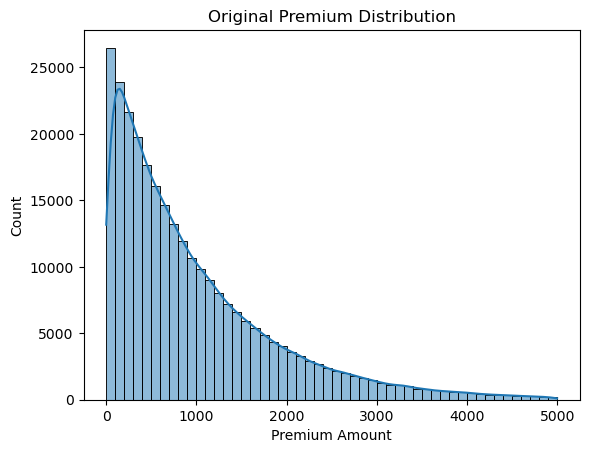

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


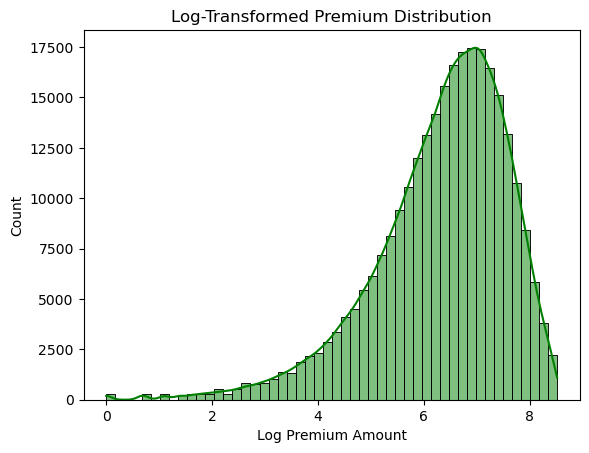

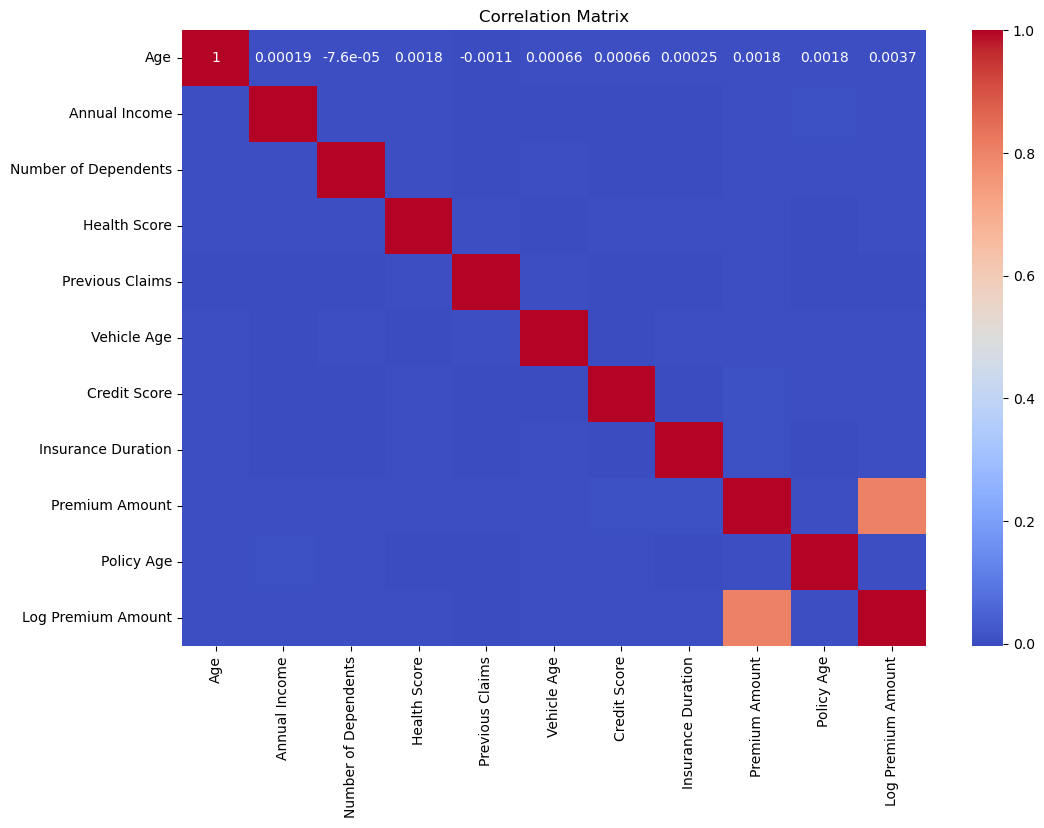

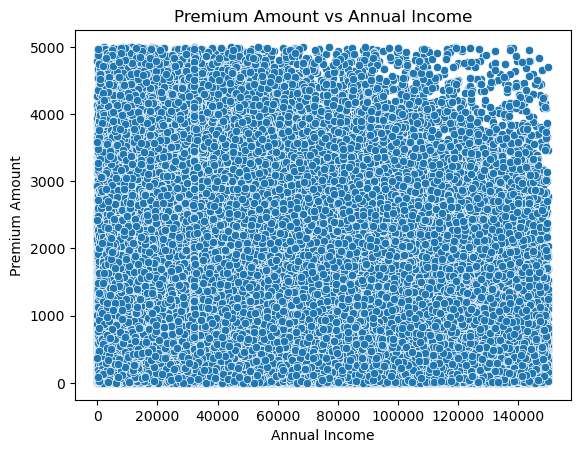

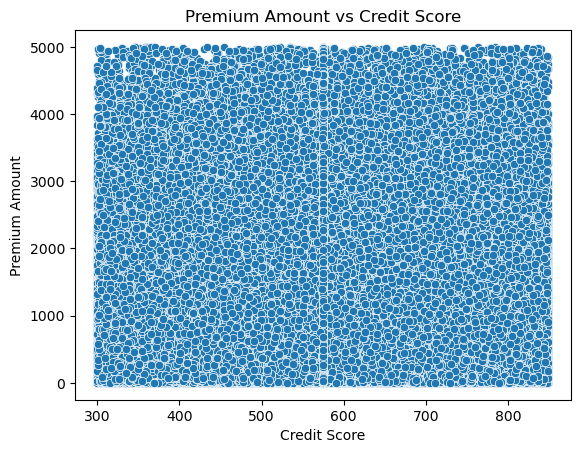

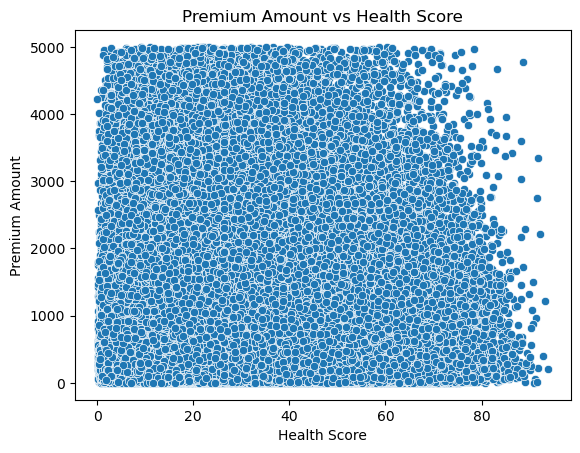

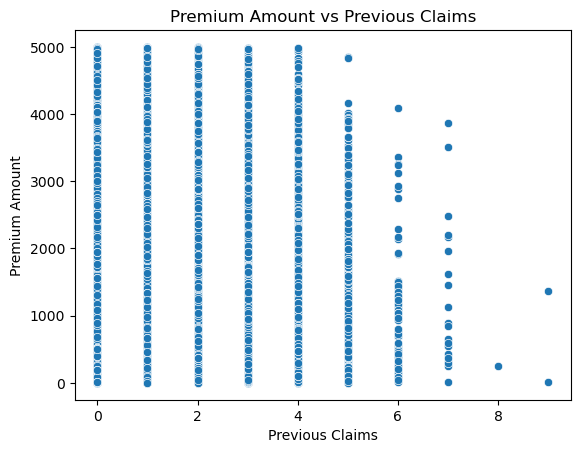

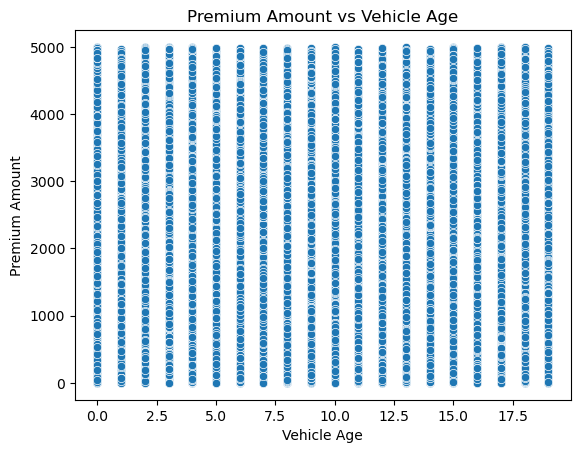

In [8]:
sns.histplot(df['Premium Amount'], bins=50, kde=True)
plt.title('Original Premium Distribution')
plt.show()

sns.histplot(df['Log Premium Amount'], bins=50, kde=True, color='green')
plt.title('Log-Transformed Premium Distribution')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Top features
top_features = ['Annual Income', 'Credit Score', 'Health Score', 'Previous Claims', 'Vehicle Age']
for feature in top_features:
    sns.scatterplot(data=df, x=feature, y='Premium Amount')
    plt.title(f'Premium Amount vs {feature}')
    plt.show()


## 3.Machine Learning Models
### -Model Evaluation
### -Residual plots for model diagnostics

In [9]:
## 4. Feature Engineering
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop(['Premium Amount', 'Policy Start Date', 'Log Premium Amount'], axis=1)
y = df_encoded['Log Premium Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

search = RandomizedSearchCV(xgb_model, param_grid, cv=3, n_iter=5, scoring='neg_mean_squared_error', n_jobs=-1)
search.fit(X_train, y_train)

best_model = search.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

print("MAE:", mean_absolute_error(y_true, y_pred))
print("MSE:", mean_squared_error(y_true, y_pred))
print("R2 Score:", r2_score(y_true, y_pred))


MAE: 674.0349819873801
MSE: 1004956.3509297046
R2 Score: -0.20653192401370424


In [11]:
# Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr_log = lr_model.predict(X_test)
y_pred_lr = np.expm1(y_pred_lr_log)  # Inverse of log1p
y_true = np.expm1(y_test)

# Evaluation
print("🔹 Linear Regression Evaluation:")
print("MAE:", mean_absolute_error(y_true, y_pred_lr))
print("MSE:", mean_squared_error(y_true, y_pred_lr))
print("R2 Score:", r2_score(y_true, y_pred_lr))


🔹 Linear Regression Evaluation:
MAE: 674.0445984534173
MSE: 1004951.2408799762
R2 Score: -0.20652578898293905


C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


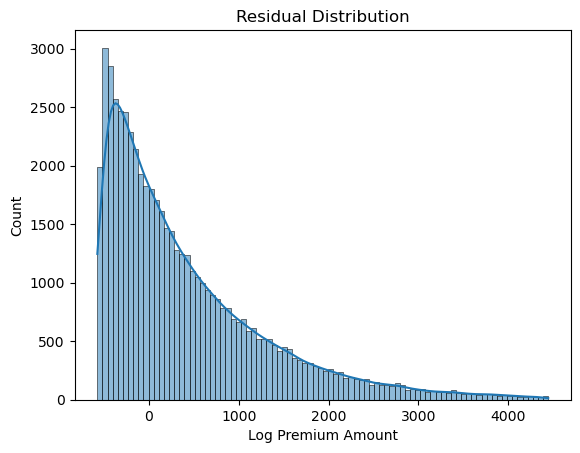

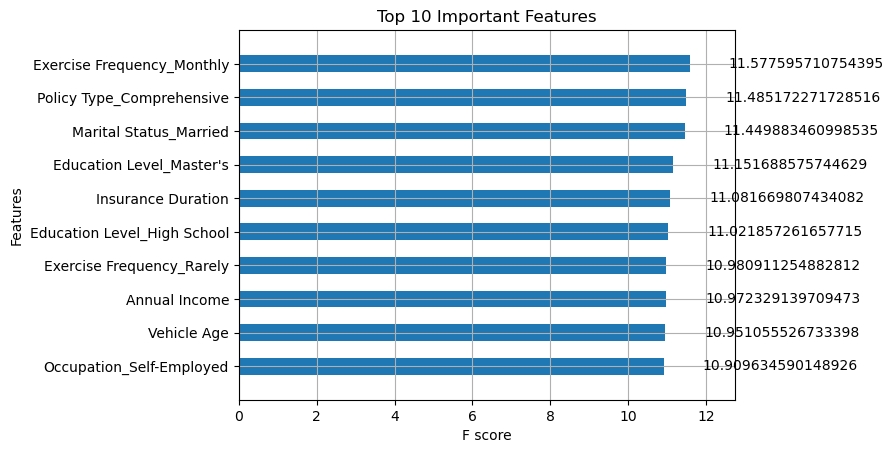

In [12]:
residuals = y_true - y_pred
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()

xgb.plot_importance(best_model, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 Important Features")
plt.show()


C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


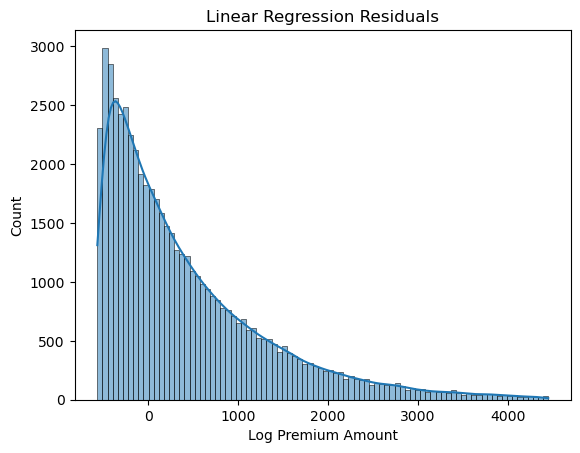

In [13]:
residuals_lr = y_true - y_pred_lr
sns.histplot(residuals_lr, kde=True)
plt.title('Linear Regression Residuals')
plt.show()


### Key Insights:
- **Income, Credit Score, Health Score, and Claims History** are highly predictive of premium.
- **Log transformation** improved model accuracy significantl
- **XGBoost** slightly outperforms Linear Regression
    Both models are underfitting based on the negative R² score. A negative R² means the model performs worse than simply           predicting the mean of the target.

    However, XGBoost has:

   Lower MAE and MSE
    Slightly better R².yst.
- **Policy Age and Vehicle Age** are also strong premium indica
''')

###  Conclusion
This project successfully demonstrates how data-driven approaches can improve premium prediction accuracy for SecureLife Insurance Co.

Data preprocessing, such as handling missing values, encoding, and log transformation, significantly improved model stability.
XGBoost was the best performing model, though further tuning and more complex feature interactions could enhance results.
This work provides a solid foundation for building an intelligent insurance pricing system.

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import joblib
import numpy as np

# Separate features and target
X = df.drop(columns=["Premium Amount", "Policy Start Date", "Customer Feedback", "Log Premium Amount"])
y = df["Log Premium Amount"]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Final model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Save model and encoder for Streamlit
joblib.dump(pipeline.named_steps['model'], "xgboost_model.pkl")
joblib.dump(pipeline.named_steps['preprocessor'], "encoder.pkl")

print("✅ Model and encoder saved for Streamlit.")


✅ Model and encoder saved for Streamlit.


In [17]:
df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Credit Score,Insurance Duration,Premium Amount,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Policy Age,Log Premium Amount
0,56.0,Male,99990.0,Married,1.0,Master's,Self-Employed,31.074627,Urban,Comprehensive,...,320.0,5,308.0,2022-12-10 15:21:39.078837,Poor,Yes,Daily,Condo,3,5.733341
1,46.0,Male,2867.0,Single,1.0,Bachelor's,Self-Employed,50.271335,Urban,Comprehensive,...,694.0,4,517.0,2023-01-31 15:21:39.078837,Good,Yes,Monthly,House,2,6.249975
2,32.0,Female,30154.0,Divorced,3.0,Bachelor's,Self-Employed,14.714909,Suburban,Comprehensive,...,652.0,8,849.0,2023-11-26 15:21:39.078837,Poor,No,Monthly,House,2,6.745236
3,60.0,Female,48371.0,Divorced,0.0,PhD,Self-Employed,25.346926,Rural,Comprehensive,...,330.0,7,927.0,2023-02-27 15:21:39.078837,Poor,No,Rarely,Condo,2,6.833032
4,25.0,Female,54174.0,Divorced,0.0,High School,Self-Employed,6.659499,Urban,Comprehensive,...,575.0,8,303.0,2020-11-25 15:21:39.078837,Poor,No,Rarely,Condo,5,5.717028
